In [1]:
!pip install torch matplotlib numpy gymnasium


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym

In [2]:
# !pip install ufal.pybox2d
# !pip install gymnasium
# !pip install pygame
# !pip install opencv-python

In [3]:
train_env = gym.make('LunarLander-v3')
test_env = gym.make('LunarLander-v3')

In [4]:
SEED = 1234

# train_env.seed(SEED);
# test_env.seed(SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.1):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [6]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()

        self.actor = actor
        self.critic = critic

    def forward(self, state):

        action_pred = self.actor(state)
        value_pred = self.critic(state)

        return action_pred, value_pred

In [7]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = test_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy = ActorCritic(actor, critic)

In [8]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [9]:
policy.apply(init_weights)

ActorCritic(
  (actor): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (critic): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [10]:
LEARNING_RATE = 0.0005

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

In [11]:
def calculate_returns(rewards, discount_factor, normalize = True):

    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)

    returns = torch.tensor(returns)

    if normalize:

        returns = (returns - returns.mean()) / returns.std()

    return returns

In [12]:
def calculate_advantages(returns, values, normalize = True):

    advantages = returns - values

    if normalize:

        advantages = (advantages - advantages.mean()) / advantages.std()

    return advantages   

In [13]:
def update_policy(advantages, log_prob_actions, returns, values, optimizer):

    advantages = advantages.detach()
    returns = returns.detach()

    policy_loss = - (advantages * log_prob_actions).sum()

    value_loss = F.smooth_l1_loss(returns, values).sum()

    optimizer.zero_grad()

    policy_loss.backward()
    value_loss.backward()

    optimizer.step()

    return policy_loss.item(), value_loss.item()

In [14]:
def evaluate(env, policy):

    policy.eval()

    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():

            action_pred, _ = policy(state)

            action_prob = F.softmax(action_pred, dim = -1)

        action = torch.argmax(action_prob, dim = -1)

        state, reward, done, _ = env.step(action.item())

        episode_reward += reward

    return episode_reward

In [15]:
def train(env, policy, optimizer, discount_factor):

    policy.train()

    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        action_pred = actor(state)
        value_pred = critic(state)

        action_prob = F.softmax(action_pred, dim = -1)

        dist = distributions.Categorical(action_prob)

        action = dist.sample()

        log_prob_action = dist.log_prob(action)

        state, reward, done, _ = env.step(action.item())

        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)

        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)

    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)

    policy_loss, value_loss = update_policy(advantages, log_prob_actions, returns, values, optimizer)

    return policy_loss, value_loss, episode_reward

In [ ]:
MAX_EPISODES = 2000
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 200
PRINT_EVERY = 10

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):

    policy_loss, value_loss, train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR)

    test_reward = evaluate(test_env, policy)

    train_rewards.append(train_reward)
    test_rewards.append(test_reward)

    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])

    if episode % PRINT_EVERY == 0:

        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:7.1f} | Mean Test Rewards: {mean_test_rewards:7.1f} |')

    # if mean_test_rewards >= REWARD_THRESHOLD:

    #     print(f'Reached reward threshold in {episode} episodes')

    #     break

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()

In [20]:
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/lunar_lander_policy.pth"
torch.save(policy.state_dict(), MODEL_PATH)
# Recreate the ActorCritic model structure
actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)
policy = ActorCritic(actor, critic)

# Load the saved state dictionary into the policy model
policy.load_state_dict(torch.load(MODEL_PATH))
policy.eval()  # Set the model to evaluation mode


RuntimeError: Parent directory /content/drive/MyDrive/Colab Notebooks does not exist.

In [21]:
import torch
import torch.nn.functional as F

def play_lunar_lander(env, policy):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        # Render the environment
        env.render()

        # Convert state to a PyTorch tensor
        state = torch.FloatTensor(state).unsqueeze(0)

        # Get action prediction from the trained policy
        with torch.no_grad():
            action_pred, _ = policy(state)  # Get action logits from the actor
            action_prob = F.softmax(action_pred, dim=-1)  # Convert to probabilities

        # Choose the action with the highest probability
        action = torch.argmax(action_prob, dim=-1).item()

        # Step in the environment
        state, reward, done, _ = env.step(action)

        # Accumulate the total reward
        total_reward += reward

    env.close()
    print(f"Total Reward: {total_reward}")

# Example usage with LunarLander-v2
# import gym
env = gym.make("LunarLander-v2")

# Play using the trained policy
play_lunar_lander(env, policy)


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\envs\box2d\lunar_lander.py:604: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("LunarLander-v2", render_mode="rgb_array")
  gym.logger.warn(
C:\Users\HP\AppData\Local\Temp\ipykernel_9068\3215299217.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  state = torch.FloatTensor(state).unsqueeze(0)


ValueError: expected sequence of length 8 at dim 1 (got 0)

In [ ]:
import gymnasium as gym
import torch
from gymnasium.wrappers import RecordVideo


actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)
policy = ActorCritic(actor, critic)

# Load the saved state dictionary into the policy model
policy.load_state_dict(torch.load('lunar_lander_policy.pth'))
policy.eval()  # Set the model to evaluation mode

# Create the environment
env = gym.make("LunarLander-v3", render_mode="rgb_array")
env = RecordVideo(env, video_folder="./videos", name_prefix="lunar_lander_test_3")

# Run the policy in the environment
state, _ = env.reset()
total = 0
done = False
frame = 0
history = []

rews=[]
frames=[]
success_count = 0
filename = "a2c.mp4"
with imageio.get_writer(filename, fps=30) as video:
    for _ in range(5):
      state, _ = env.reset()
      total = 0
      done = False
      frame = 0
      history = []
      reward=0
      frame_counter=0
      while not done:
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0)  
        with torch.no_grad():  
            action_pred, _ = policy(state_tensor)  

        action_prob = F.softmax(action_pred, dim=-1)  
        action = torch.argmax(action_prob, dim=-1)  
        state, rew, done, _, _ = env.step(action.item())
        reward+=rew
        video.append_data(env.render())
        frame_counter+=1
      print('Episode reward:', reward, 'Number of frames:', frame_counter)
env.close()

print("Video saved to './videos'")

C:\Users\HP\AppData\Local\Temp\ipykernel_19780\3024843526.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load('lunar_lander_policy.pth'))


Episode reward: 263.2251290163955 Number of frames: 398
Episode reward: 232.18414202066472 Number of frames: 307
Episode reward: 244.2906999590402 Number of frames: 467
Episode reward: 243.5489376627326 Number of frames: 342
Episode reward: -70.7104461368815 Number of frames: 886
Video saved to './videos'


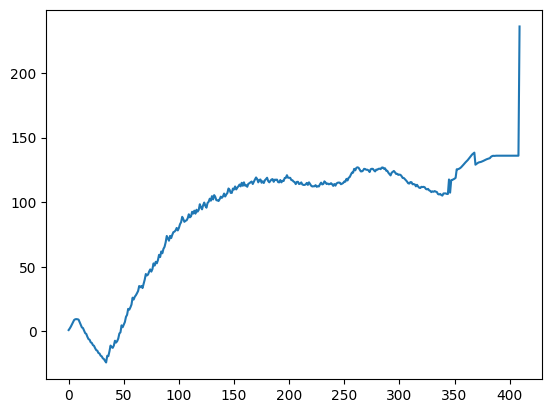

In [19]:
plt.plot(history)

In [ ]:

import cv2
from IPython.display import HTML
from base64 import b64encode

def play_replay(filename="/content/drive/MyDrive/Colab Notebooks/replay.mp4"):
  mp4 = open(filename,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

play_replay()